# https://www.kaggle.com/code/bansodesandeep/sentiment-analysis-support-vector-machine/notebook

In [6]:
#importing req. Lib.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [7]:
data = pd.read_csv('./Tweets.csv')

In [8]:
data['tweet_created'] = pd.to_datetime(data['tweet_created']).dt.date

In [9]:
data['tweet_created'] = pd.to_datetime(data['tweet_created'])

In [10]:
numberoftweets = data.groupby('tweet_created').size()

In [11]:
numberoftweets.dtype


dtype('int64')

In [12]:
del data['tweet_coord']
del data['airline_sentiment_gold']
del data['negativereason_gold']
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24,NaN,Pacific Time (US & Canada)


In [13]:
freq = data.groupby('negativereason').size()


In [14]:
freq


negativereason
Bad Flight                      580
Can't Tell                     1190
Cancelled Flight                847
Customer Service Issue         2910
Damaged Luggage                  74
Flight Attendant Complaints     481
Flight Booking Problems         529
Late Flight                    1665
Lost Luggage                    724
longlines                       178
dtype: int64

Total number of tweets for each airline 
  airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64


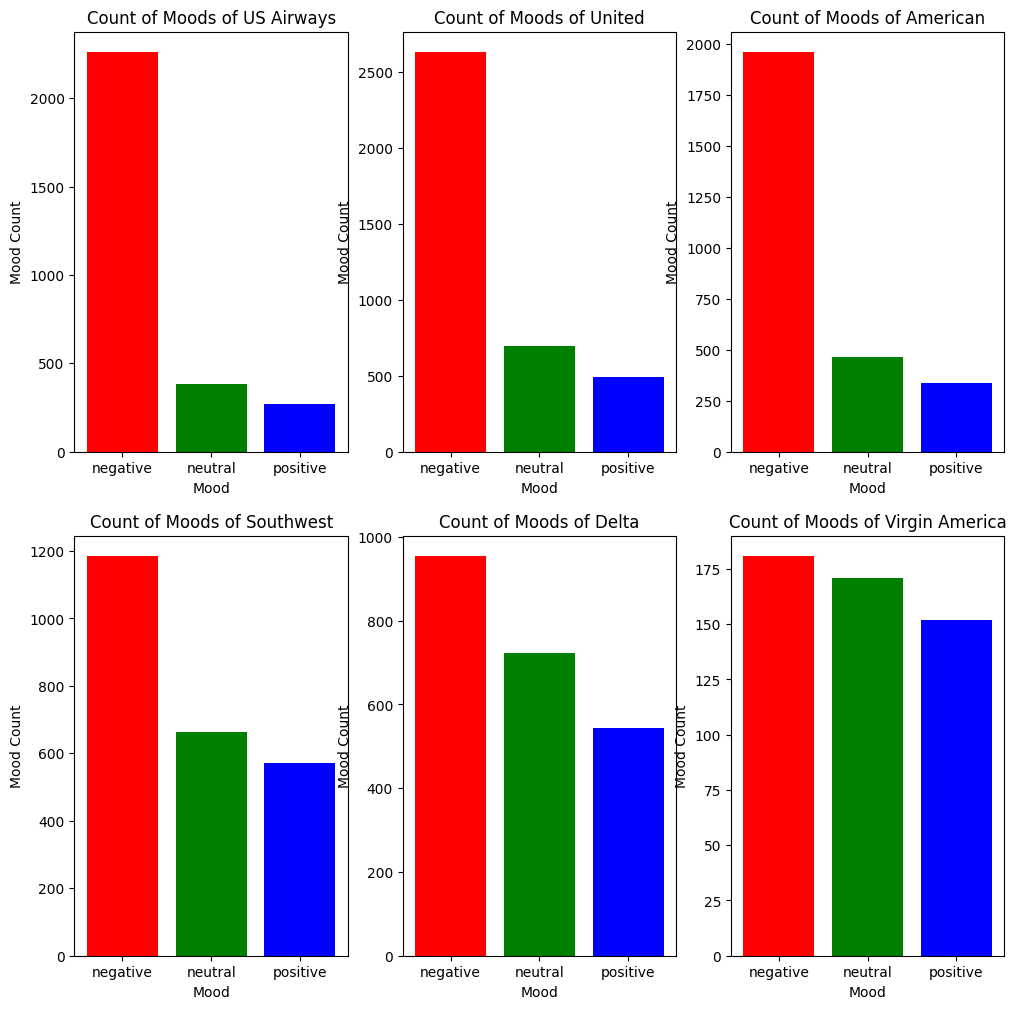

In [15]:
print("Total number of tweets for each airline \n ",data.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
plt.figure(1,figsize=(12, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=data[data['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)

            Percent Negative
American            0.710402
Delta               0.429793
Southwest           0.490083
US Airways          0.776862
United              0.688906
Virgin              0.359127


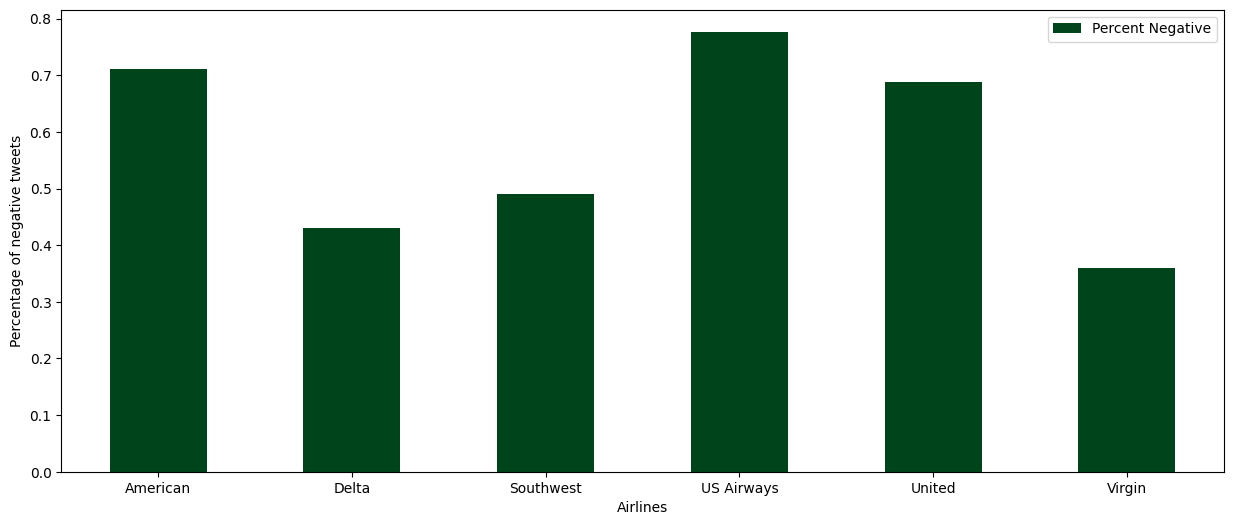

In [16]:
neg_tweets = data.groupby(['airline','airline_sentiment']).count().iloc[:,0]
total_tweets = data.groupby(['airline'])['airline_sentiment'].count()

my_dict = {'American':neg_tweets[0] / total_tweets[0],'Delta':neg_tweets[3] / total_tweets[1],'Southwest': neg_tweets[6] / total_tweets[2],
'US Airways': neg_tweets[9] / total_tweets[3],'United': neg_tweets[12] / total_tweets[4],'Virgin': neg_tweets[15] / total_tweets[5]}
perc = pd.DataFrame.from_dict(my_dict, orient = 'index')
perc.columns = ['Percent Negative']
print(perc)
ax = perc.plot(kind = 'bar', rot=0, colormap = 'Greens_r', figsize = (15,6))
ax.set_xlabel('Airlines')
ax.set_ylabel('Percentage of negative tweets')
plt.show()

<Axes: xlabel='airline'>

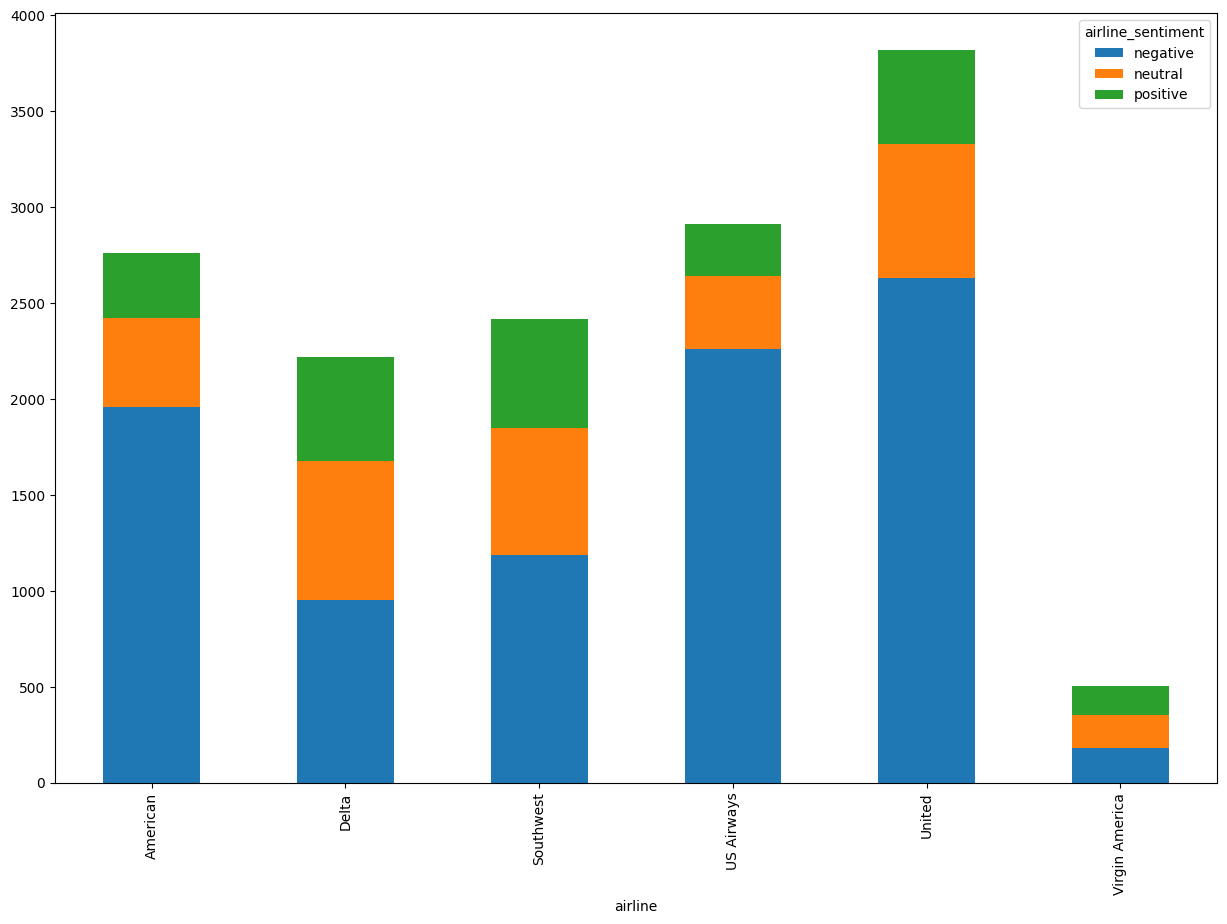

In [17]:
figure_2 = data.groupby(['airline', 'airline_sentiment']).size()
figure_2.unstack().plot(kind='bar', stacked=True, figsize=(15,10))

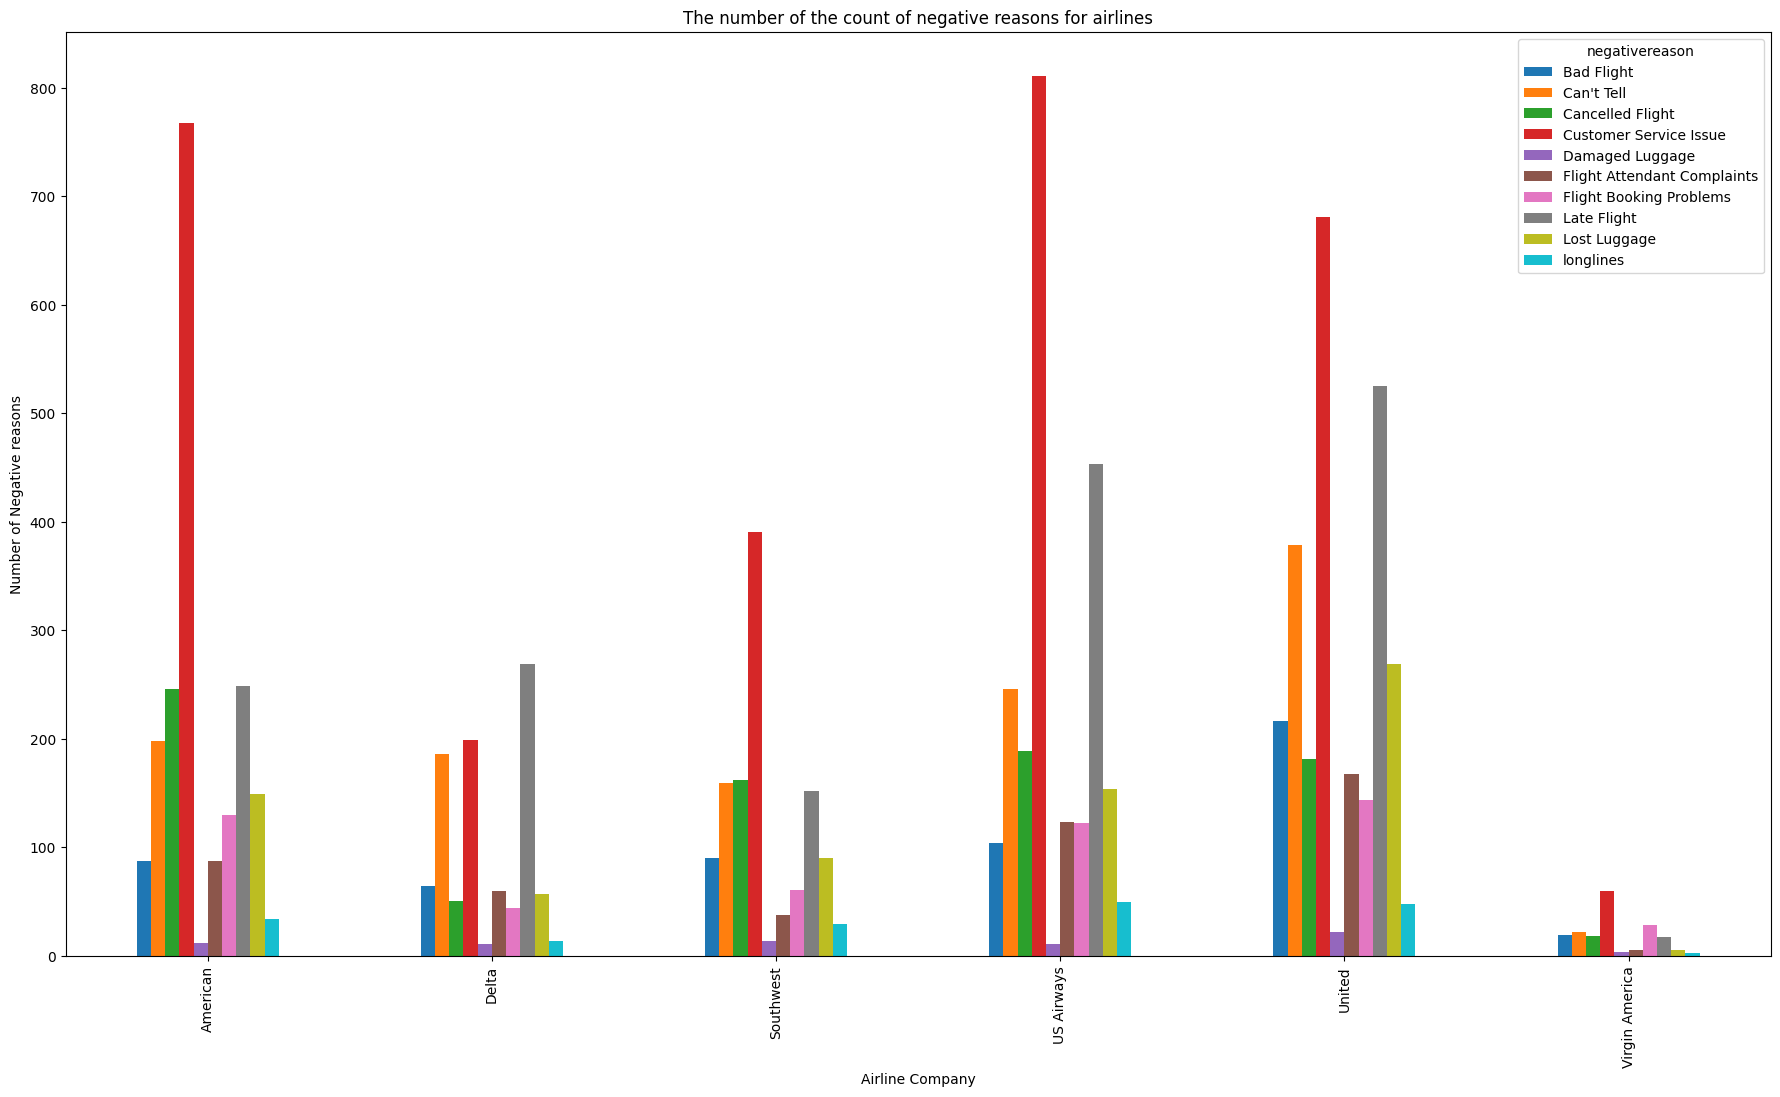

In [18]:
negative_reasons = data.groupby('airline')['negativereason'].value_counts(ascending=True)
negative_reasons.groupby(['airline','negativereason']).sum().unstack().plot(kind='bar',figsize=(22,12))
plt.xlabel('Airline Company')
plt.ylabel('Number of Negative reasons')
plt.title("The number of the count of negative reasons for airlines")
plt.show()

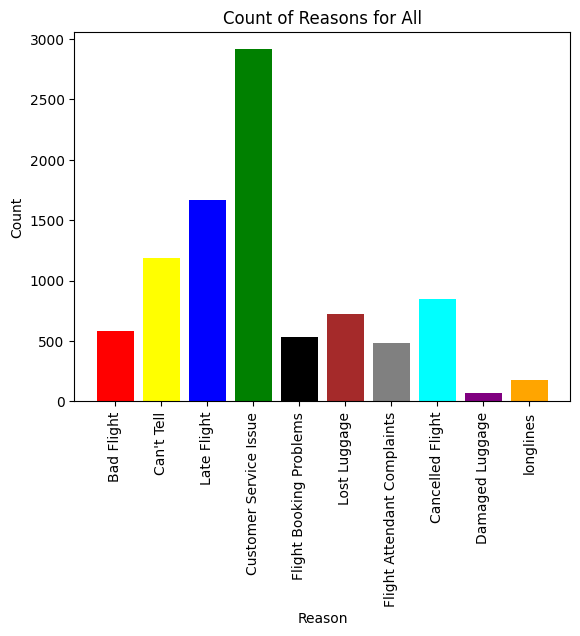

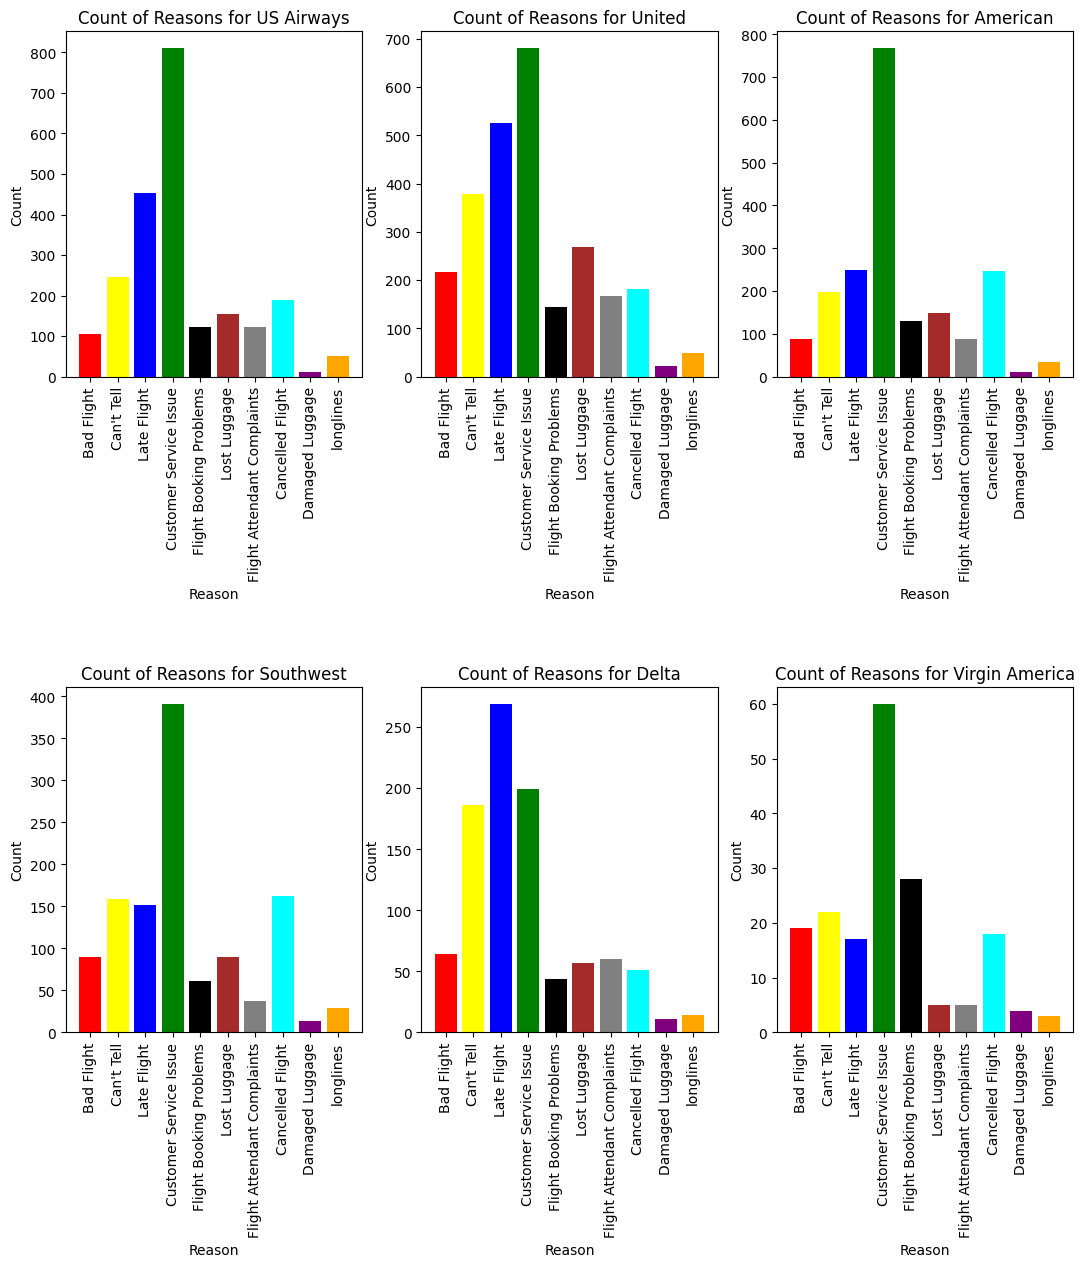

In [19]:
#get the number of negative reasons
data['negativereason'].nunique()

NR_Count=dict(data['negativereason'].value_counts(sort=False))
def NR_Count(Airline):
    if Airline=='All':
        a=data
    else:
        a=data[data['airline']==Airline]
    count=dict(a['negativereason'].value_counts())
    Unique_reason=list(data['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame
def plot_reason(Airline):
    
    a=NR_Count(Airline)
    count=a['count']
    Index = range(1,(len(a)+1))
    plt.bar(Index,count, color=['red','yellow','blue','green','black','brown','gray','cyan','purple','orange'])
    plt.xticks(Index,a['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)
    
plot_reason('All')
plt.figure(2,figsize=(13, 13))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)

In [20]:
date = data.reset_index()
#convert the Date column to pandas datetime
date.tweet_created = pd.to_datetime(date.tweet_created)
#Reduce the dates in the date column to only the date and no time stamp using the 'dt.date' method
date.tweet_created = date.tweet_created.dt.date
date.tweet_created.head()
df = date
day_df = df.groupby(['tweet_created','airline','airline_sentiment']).size()
# day_df = day_df.reset_index()
day_df

tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative               1
                               neutral                1
               United          negative               2
2015-02-17     Delta           negative             108
                               neutral               86
                                                   ... 
2015-02-24     United          neutral               49
                               positive              25
               Virgin America  negative              10
                               neutral                6
                               positive              13
Length: 136, dtype: int64

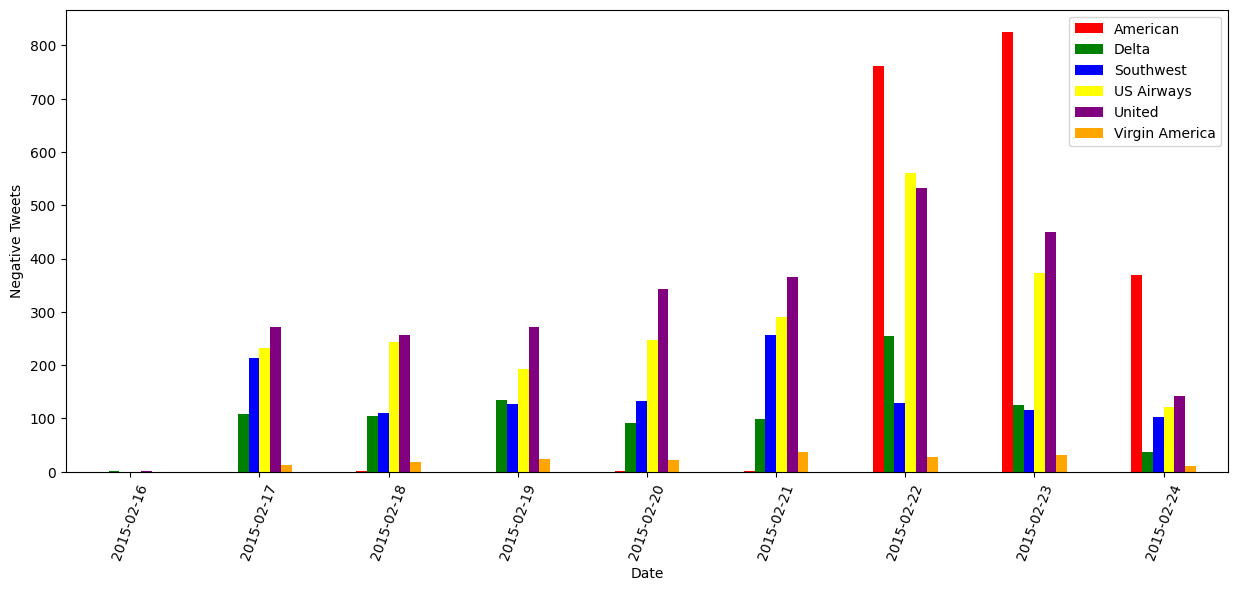

In [21]:
day_df = day_df.loc(axis=0)[:,:,'negative']

#groupby and plot data
ax2 = day_df.groupby(['tweet_created','airline']).sum().unstack().plot(kind = 'bar', color=['red', 'green', 'blue','yellow','purple','orange'], figsize = (15,6), rot = 70)
labels = ['American','Delta','Southwest','US Airways','United','Virgin America']
ax2.legend(labels = labels)
ax2.set_xlabel('Date')
ax2.set_ylabel('Negative Tweets')
plt.show()

In [25]:
from wordcloud import WordCloud,STOPWORDS


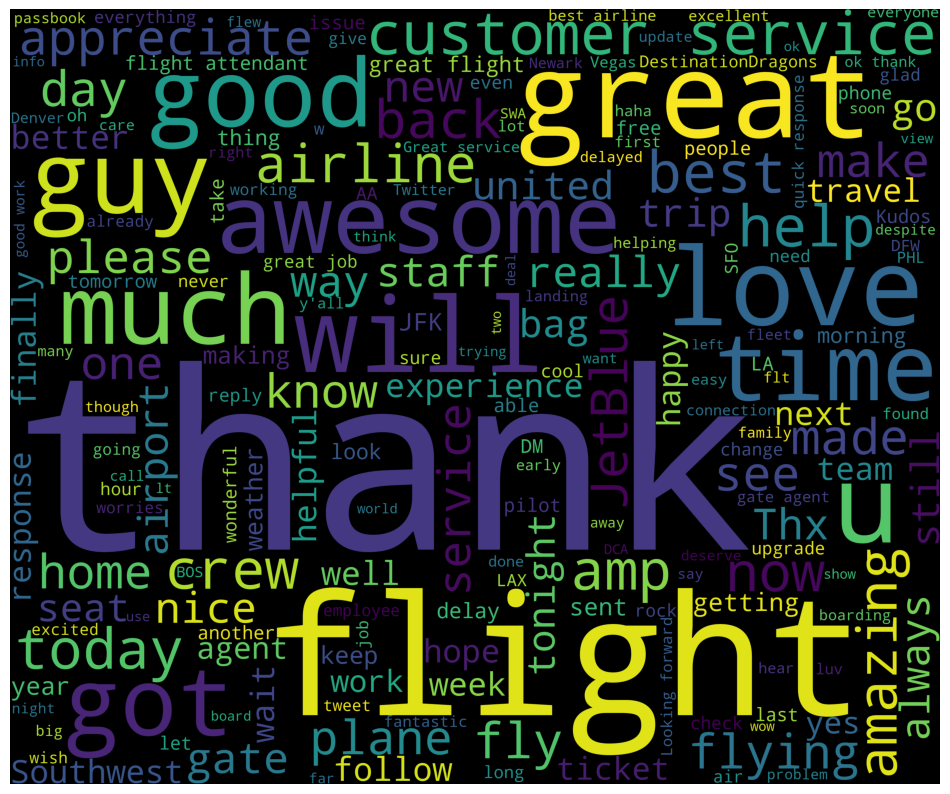

In [26]:
new_df=data[data['airline_sentiment']=='positive']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

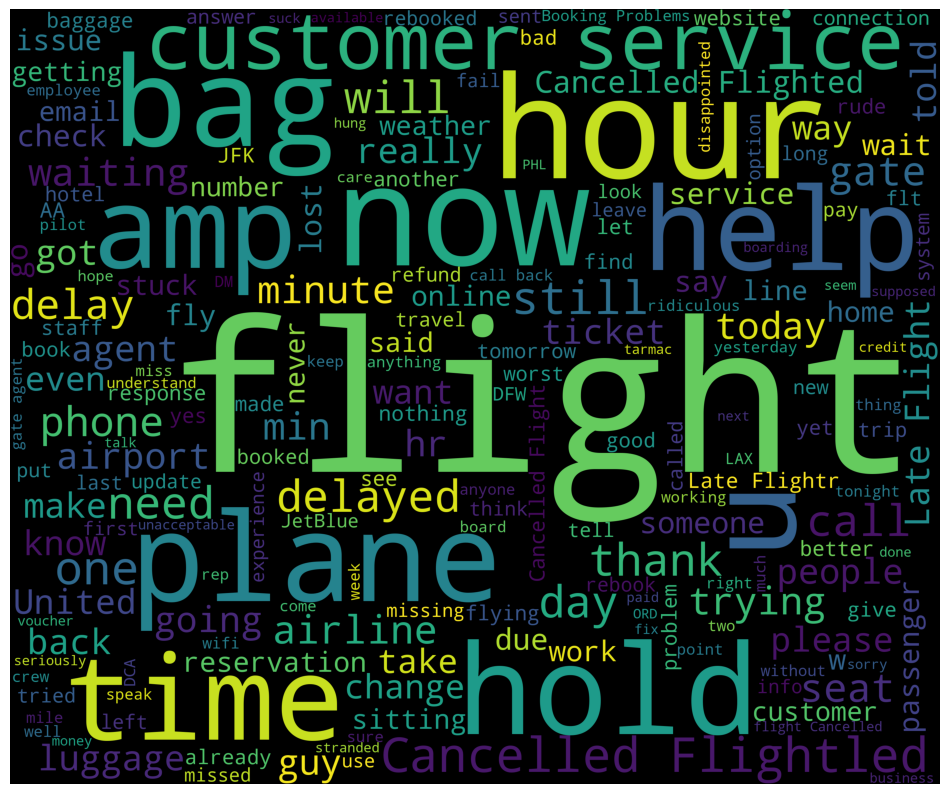

In [27]:
new_df=data[data['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [28]:
data.drop(data.loc[data['airline_sentiment']=='neutral'].index, inplace=True)

In [29]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(data['airline_sentiment'])

data['airline_sentiment_encoded'] = le.transform(data['airline_sentiment'])
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,airline_sentiment_encoded
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24,NaN,Pacific Time (US & Canada),1
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24,NaN,Pacific Time (US & Canada),0
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24,NaN,Pacific Time (US & Canada),0
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...,2015-02-24,NaN,Pacific Time (US & Canada),0
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX...",2015-02-24,San Francisco CA,Pacific Time (US & Canada),1


In [30]:
def tweet_to_words(tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words ))

In [31]:
nltk.download('stopwords')
data['clean_tweet']=data['text'].apply(lambda x: tweet_to_words(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
x = data.clean_tweet
y = data.airline_sentiment

print(len(x), len(y))

11541 11541


In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

8655 8655
2886 2886


In [34]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [35]:
# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

In [36]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)
vect_tunned

CountVectorizer(max_df=0.7, max_features=100, min_df=0.1, ngram_range=(1, 2),
                stop_words='english')

In [37]:
#training SVM model with linear kernel
#Support Vector Classification-wrapper around SVM
from sklearn.svm import SVC
model = SVC(kernel='linear', random_state = 10)
model.fit(x_train_dtm, y_train)
#predicting output for test data
pred = model.predict(x_test_dtm)

In [38]:
#accuracy score
accuracy_score(y_test,pred)

0.9081774081774082